# CRM 애널리틱스: 이커머스 판매 데이타

## < 프로젝트 소개 >
온라인몰의 판매 데이터를 통해 RFM, 코호트, 세그멘테이션, 고객 생애 가지 분석을 실시한다. 해당 온라인몰은 유럽을 기반으로 영국을 주된 시장을 하여 다양한 생활용품들을 판매하는 회사이다.


## < 데이터파일 >
- data.csv (대용량 파일로 첨부하지 않음: 45.6MB)

## < 데이타 필드 >
- InvoiceNo: 인보이스 번호로 숫자 6자로 되어 있음. 취소된 주문이면 번호앞에 C로 시작된다.
- StockCode: 제품번호로 숫자5자리로 이뤄져 있다.
- Description: 제품 이름
- Quantity: 주문당 제품의 갯수
- InvoiceDate: 주문이 이뤄진 날짜와 시간
- UnitPrice: 제품 개당 가격
- CustomerID: 고객마다 특정한 고객 ID가지고 있으면 이 숫자는 5개의 숫자로 이뤄져 있다.
- Country: 고객이 거주하고 있는 국가 이름

## < 분석 방법 >
- RFM Analysis
- Cohort Analysis
- Segmentation Anlysis
- Customer Lifetime Value

## < 목차 >
1. Libraries and Utillities
2. Load and Check data
3. Undestand Data
4. Data Preprocessing
5. RFM Analysis
6. Cohort Analysis
7. Customer Lifetime Value

### Credits
- https://www.kaggle.com/code/sercanyesiloz/crm-analytics/notebook
- https://assaeunji.github.io/data-analysis/2022-06-06-ltv-practice/


# 1. Libraries and Utilities

In [140]:
import squarify
import warnings

import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from operator import attrgetter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
palette = "Set2"

# 2. Load and Check Data

InvoiceNo, CustomerID, InvoiceDate의 데이타 타입을 바꿔준다.

In [2]:
df = pd.read_csv(
    "data.csv",
    header=0,
    encoding="unicode_escape",
    dtype={"CustomerID": str, "InvoiceNo": str},
    parse_dates=["InvoiceDate"],
    infer_datetime_format=True,
)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# 3. Understand Data

데이타의 구조와 누락된 값이 있는지 알아 본다.

In [4]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70, "-"))
    print("Rows: {}".format(dataframe.shape[0]))
    print("Columns: {}".format(dataframe.shape[1]))
    print(" TYPES ".center(70, "-"))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, "-"))
    print(dataframe.head(head))
    print(" TAIL ".center(70, "-"))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70, "-"))
    print(dataframe.isnull().sum())
    print(" DUPLIACATED VALUES ".center(70, "-"))
    print(dataframe.duplicated().sum())
    print(" DESCRIPTIVE STATSTICS ".center(70, "-"))
    print(dataframe.describe([0, 0.01, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 0

#### 짚고가야 할 점들
- Quantity, UnitPrice 열에 이상치가 있다.
- Quantity and UnitPrice 열에 취소된 주문으로 인해 마이너스 값이 있다.
- 또한 Description, CustomerID 열에 누락된 값이 있다.
- Quantity, UnitPrice 열을 곱해 새로운 TotalPrice 열을 만든다.

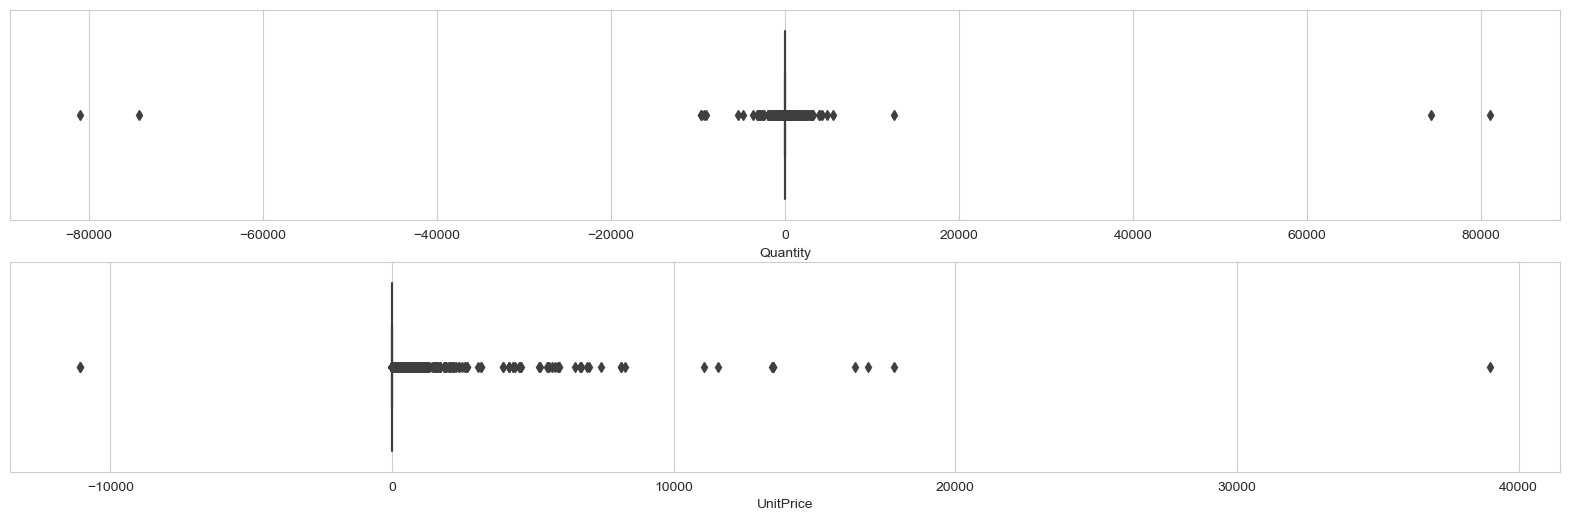

In [5]:
# 시각화를 이용해 이상치를 찾아본다

plt.figure(figsize=(20,6))

plt.subplot(211)
sns.boxplot(x='Quantity', data=df)

plt.subplot(212)
sns.boxplot(x='UnitPrice', data=df)

plt.show()

데이터의 결측치, 이상치를 살펴보는 것 외에, 이 온라인몰의 월별 판매량과 국가별 판매량, 그리고 가장 잘 팔리는 제품의 순위를 알아보자

In [6]:
# 월별 판매량, 취소금액(환불), 순판매량(판매량 - 최소금액)

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['y-m'] = df['InvoiceDate'].dt.strftime('%Y-%m')
df['p_c'] = df['InvoiceNo'].apply(lambda x: 'purchased' if x.find('C') == -1 else 'canceled')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,y-m,p_c
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,purchased
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,purchased
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,purchased
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,purchased
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,purchased
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12,purchased
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12,purchased
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,purchased
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,purchased


In [7]:
monthly_p_c = df.pivot_table('TotalPrice', 'y-m', 'p_c', aggfunc='sum')
monthly_p_c['sales'] = monthly_p_c['canceled'] + monthly_p_c['purchased']
monthly_p_c.reset_index(inplace=True)
monthly_p_c

p_c,y-m,canceled,purchased,sales
0,2010-12,-74789.12,823746.140,748957.020
1,2011-01,-131364.30,691364.560,560000.260
2,2011-02,-25569.24,523631.890,498062.650
3,2011-03,-34372.28,717639.360,683267.080
4,2011-04,-44601.50,537808.621,493207.121
5,2011-05,-47202.51,770536.020,723333.510
6,2011-06,-70616.78,761739.900,691123.120
7,2011-07,-37921.08,719221.191,681300.111
8,2011-08,-54333.75,737014.260,682680.510
9,2011-09,-38902.55,1058590.172,1019687.622


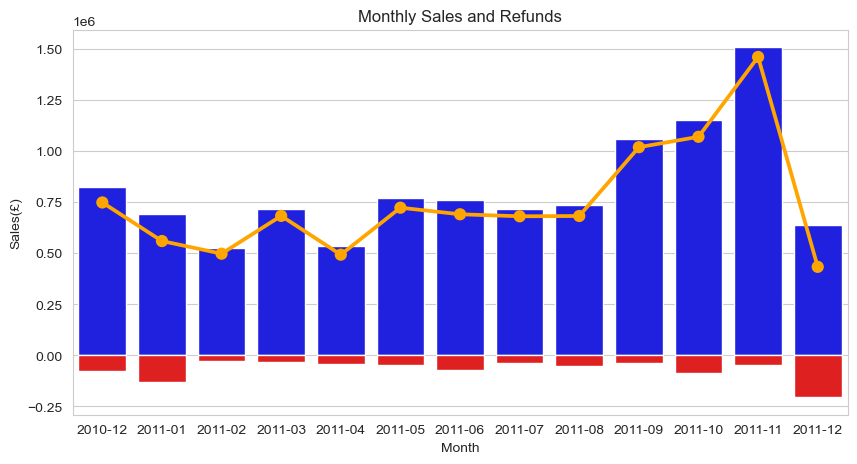

In [8]:
# Note: The sales of Dec 2011 is considerabley small due to the short period, 2011-12-1 to 12-9
plt.figure(figsize=(10,5))

sns.barplot(x='y-m', y='purchased', data=monthly_p_c, color= 'blue', label='Sales')
sns.barplot(x='y-m', y='canceled', data=monthly_p_c, color= 'red', label='Canceled Price')
sns.pointplot(x='y-m', y='sales', data=monthly_p_c, color= 'orange',label='Net Sales')
plt.title('Monthly Sales and Refunds')
plt.xlabel('Month')
plt.ylabel('Sales(£)')

plt.show()

In [9]:
# 국가별 판매량을 알아보자

sales_by_country = df.groupby('Country')[['TotalPrice']].sum().sort_values('TotalPrice', ascending=False)
sales_by_country['portion'] = sales_by_country['TotalPrice']/sales_by_country['TotalPrice'].sum()
sales_by_country.reset_index(inplace=True)
sales_by_country

,Country,TotalPrice,portion
0,United Kingdom,8187806.364,0.839969
1,Netherlands,284661.540,0.029203
2,EIRE,263276.820,0.027009
3,Germany,221698.210,0.022744
4,France,197403.900,0.020251
5,Australia,137077.270,0.014062
6,Switzerland,56385.350,0.005784
7,Spain,54774.580,0.005619
8,Belgium,40910.960,0.004197
9,Sweden,36595.910,0.003754


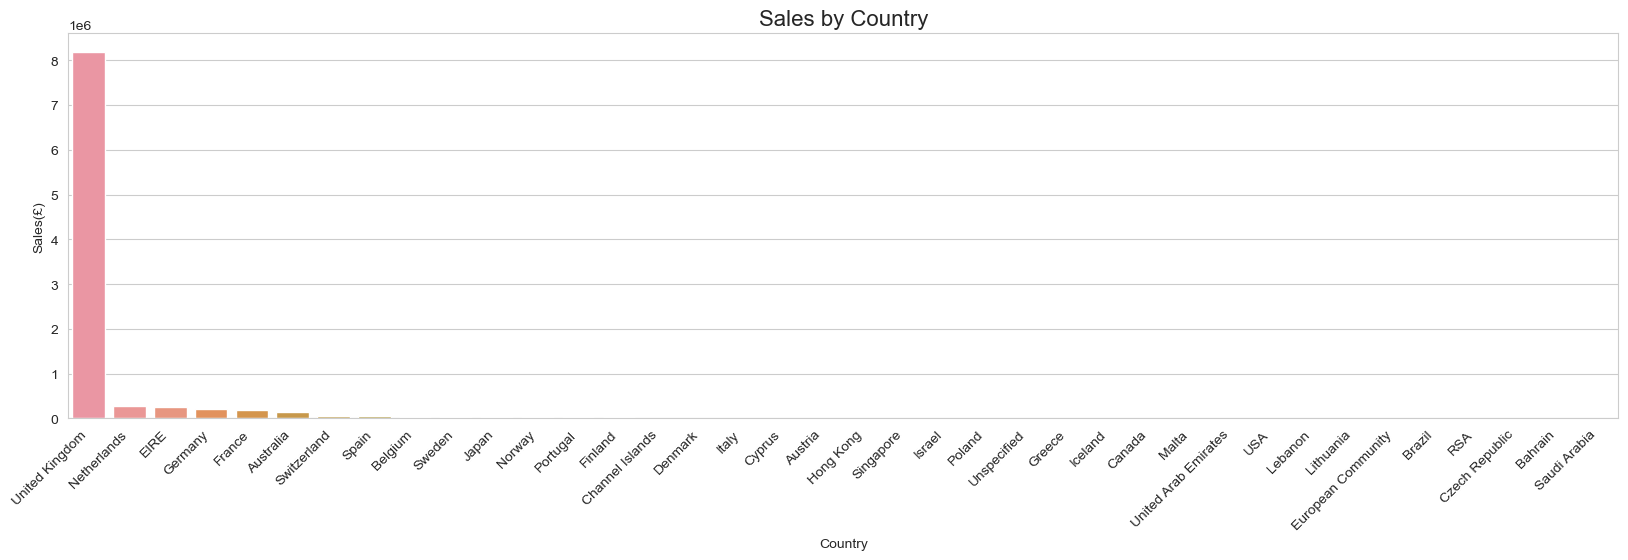

In [10]:
# 국가별 판매량의 barplot을 시각화 해본다.

plt.figure(figsize=(20,5))

ax = sns.barplot(x='Country', y='TotalPrice', data=sales_by_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=10)
plt.title('Sales by Country', fontsize=16)
plt.ylabel('Sales(£)')

plt.show()

In [11]:
# 상위 10 판매량 제품을 찾아보자

sales_by_item = df.pivot_table('TotalPrice', 'Description', 'p_c', aggfunc='sum')
sales_by_item['net_sales'] = sales_by_item['canceled'] + sales_by_item['purchased']
sales_by_item['cancel_rate'] =  np.abs(sales_by_item['canceled']) / sales_by_item['purchased']
sales_by_item['sales_ranking'] = sales_by_item['net_sales'].rank(method='first', ascending=False)

top10_items = sales_by_item.sort_values('sales_ranking')[:10]
top10_items

p_c,canceled,purchased,net_sales,cancel_rate,sales_ranking
Description,,,,,
DOTCOM POSTAGE,-3.29,206248.77,206245.48,0.000016,1.0
REGENCY CAKESTAND 3 TIER,-9722.55,174484.74,164762.19,0.055721,2.0
WHITE HANGING HEART T-LIGHT HOLDER,-6624.30,106292.77,99668.47,0.062321,3.0
PARTY BUNTING,-1201.35,99504.33,98302.98,0.012073,4.0
JUMBO BAG RED RETROSPOT,-1984.02,94340.05,92356.03,0.021031,5.0
RABBIT NIGHT LIGHT,-208.40,66964.99,66756.59,0.003112,6.0
POSTAGE,-11871.24,78101.88,66230.64,0.151997,7.0
PAPER CHAIN KIT 50'S CHRISTMAS,-1160.35,64952.29,63791.94,0.017865,8.0
ASSORTED COLOUR BIRD ORNAMENT,-135.20,59094.93,58959.73,0.002288,9.0


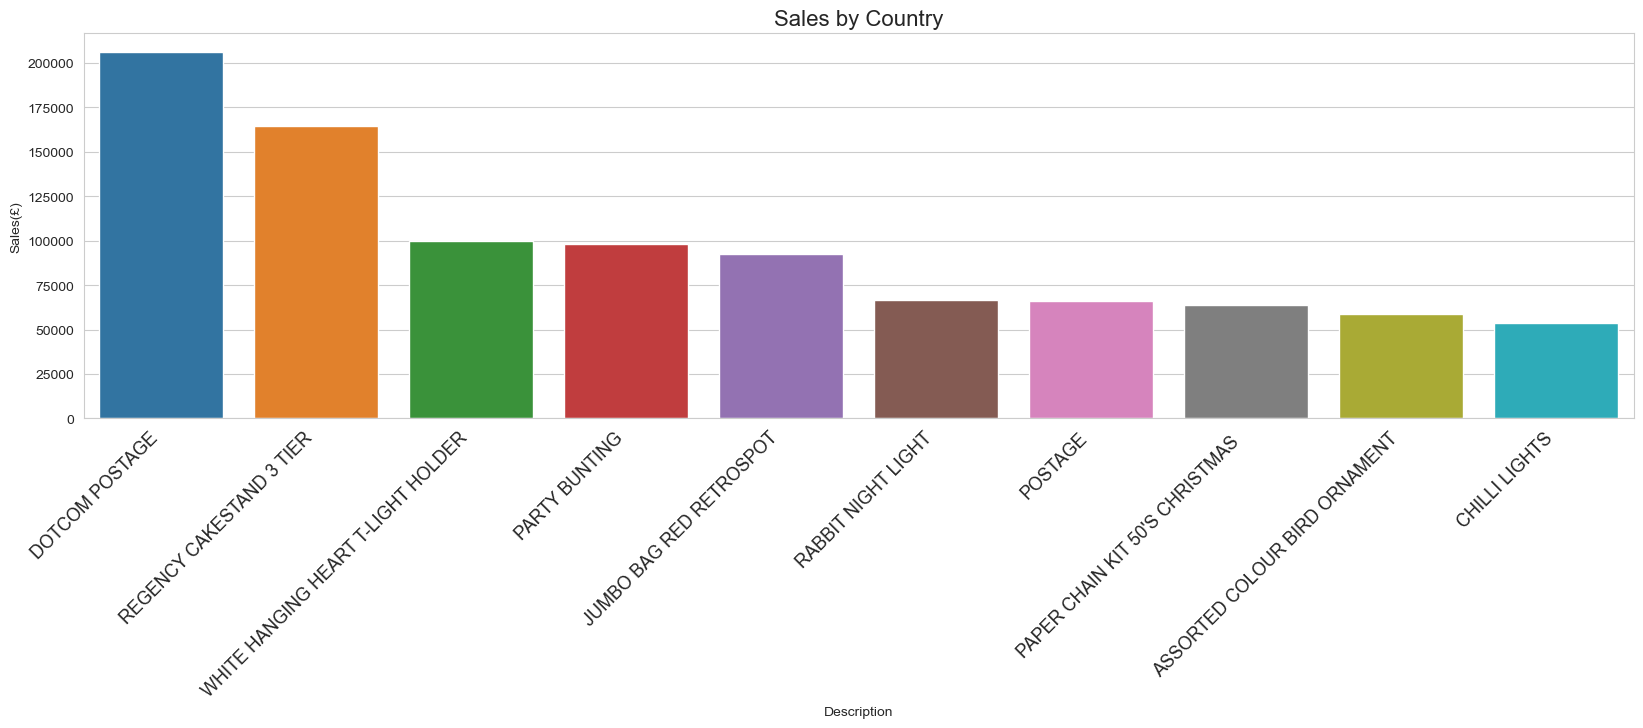

In [12]:
plt.figure(figsize=(20,5))

ax = sns.barplot(x=top10_items.index, y='net_sales', data=top10_items)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=13)
plt.title('Sales by Country', fontsize=16)
plt.ylabel('Sales(£)')

plt.show()

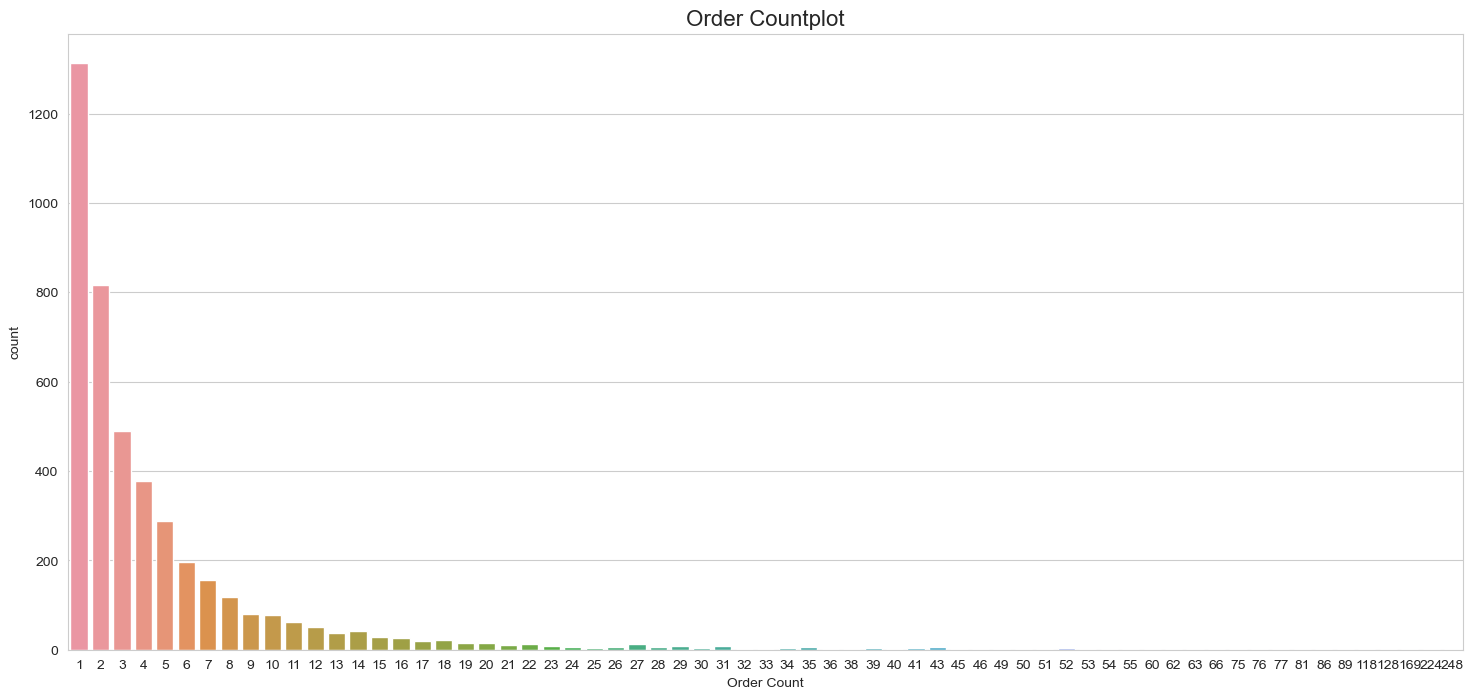

In [13]:
# Look at the user oder countplot
order_by_user = df.groupby('CustomerID')[['InvoiceNo']].nunique()


plt.figure(figsize=(18, 8))
sns.countplot(x='InvoiceNo', data=order_by_user)
plt.title('Order Countplot', fontsize=16)
plt.xlabel('Order Count')
plt.show()

In [14]:
# Take a look at an average monthly user order

monthly_order_by_user = df.groupby(['CustomerID', 'y-m'])[['InvoiceNo']].nunique()
monthly_order_by_user.columns=['order_counts']
monthly_order_by_user

order_counts
CustomerID y-m                  
12346      2011-01             2
12347      2010-12             1
           2011-01             1
           2011-04             1
           2011-06             1
...                          ...
18283      2011-10             1
           2011-11             4
           2011-12             1
18287      2011-05             1
           2011-10             2

[13675 rows x 1 columns]

In [15]:
monthly_order_by_user.groupby('CustomerID').mean()

,order_counts
CustomerID,
12346,2.0
12347,1.0
12348,1.0
12349,1.0
12350,1.0
...,...
18280,1.0
18281,1.0
18282,1.5


In [16]:
monthly_order_by_user.groupby('CustomerID').mean().describe().T

,count,mean,std,min,25%,50%,75%,max
order_counts,4372.0,1.369582,0.796565,1.0,1.0,1.0,1.5,19.076923


=>> A Users make about 1.4 orders per month on average.

In [17]:
# 전처리전 월별 판매량을 알아보기 위해 만들었던 'y-m', 'p_c'열을 삭제한다.

df.drop(['y-m', 'p_c'], axis=1, inplace=True)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


# 4. Data Preprocessing

Here, we'll create a new column of TotalPrice and remove outliers with the IQR method.

In [18]:
# IQR 방법을 이용해 이상치를 제거하는 함수를 만든다.
# quartile의 값을 0.01과 0.99로 설정한다.

def replace_with_threshold(dataframe, variable):
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(0.01)
    quartile3 = df_[variable].quantile(0.99)
    IQR = quartile3 - quartile1

    up_limit = quartile3 + IQR * 1.5
    low_limit = quartile1 - IQR * 1.5
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_


def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()

    # 누락된 값이 있는 행은 삭제한다.
    df_ = df_.dropna()

    # 취소된 주문이 있는 행도 삭제한다.
    df_ = df_[~df_["InvoiceNo"].str.contains("C", na=False)]
    df_ = df_[df_["Quantity"] > 0]

    # 이상치를 삭제한다.
    df_ = replace_with_threshold(df_, "Quantity")
    df_ = replace_with_threshold(df_, "UnitPrice")

    # TotalPrice 열을 새로 만든다
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]

    return df_


df = ecommerce_preprocess(df)

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [20]:
df.describe([0, 0.01, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,1%,5%,50%,95%,99%,100%,max
Quantity,397924.0,11.833736,25.534512,1.0,1.0,1.00,1.00,6.00,36.0,120.00,298.500,298.500
UnitPrice,397924.0,2.893163,3.227059,0.0,0.0,0.21,0.42,1.95,8.5,14.95,37.060,37.060
TotalPrice,397924.0,20.627751,51.826400,0.0,0.0,0.55,1.25,11.80,67.5,183.60,3268.575,3268.575


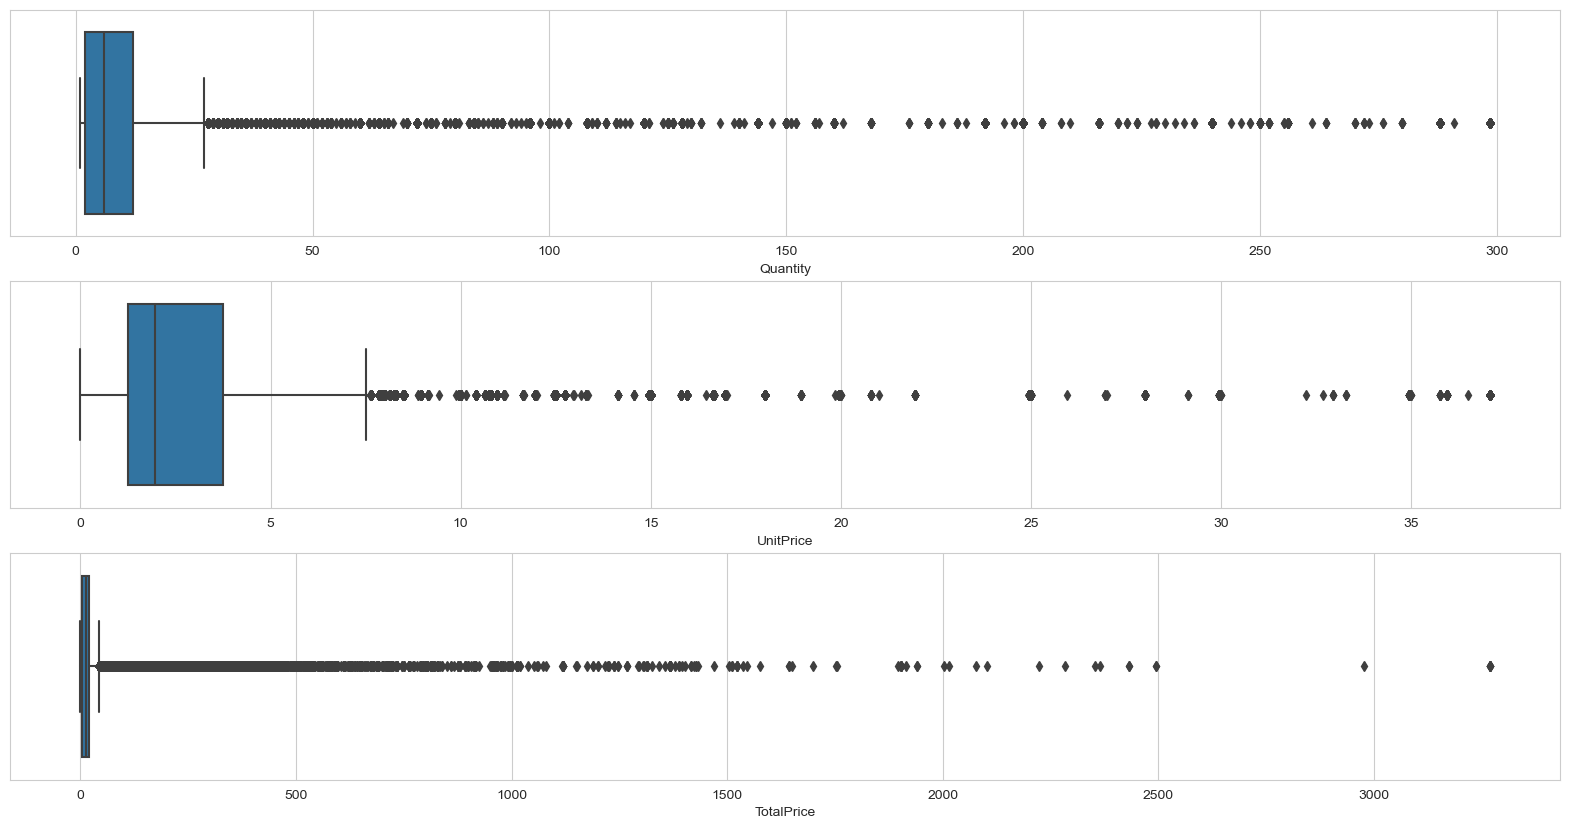

In [21]:
# 이상치 제거 후의 플롯을 그려본다.

plt.figure(figsize=(20,10))

plt.subplot(311)
sns.boxplot(x='Quantity', data=df)

plt.subplot(312)
sns.boxplot(x='UnitPrice', data=df)

plt.subplot(313)
sns.boxplot(x='TotalPrice', data=df)

plt.show()

# 5. RFM Analysis

RFM은 Recency, Frequency, Monetary를 의미하며 고객의 중요한 특성을 나타낸다. RFM은 고객의 중요한 행동을 측정하는 기준이 된다. monetary value는 생애 고객 가치값에, recency는 리텐션과 고객의 활동성에 영향을 준다.

## 5.1 RFM Metrics

In [22]:
# InvoiceDate 열에서 가장 최근의 날짜를 확인한다.

print(df.InvoiceDate.max())

2011-12-09 12:50:00


In [23]:
# recency 계산을 위해 오늘의 날짜를 여기에 2일 더하여 설정한다.

today_date = dt.datetime(2011, 12, 11)
today_date

datetime.datetime(2011, 12, 11, 0, 0)

In [24]:
# 각 고객의 receny, frequency, monetary value값을 계산한다.

rfm = df.groupby("CustomerID").agg(
    {
        "InvoiceDate": lambda x: (today_date - x.max()).days,
        "InvoiceNo": lambda x: x.nunique(),
        "TotalPrice": lambda x: x.sum(),
    }
)

# 열의 이름을 다시 설정
rfm.columns = ["recency", "frequency", "monetary"]

# 인덱스도 재설정 한다
rfm = rfm.reset_index()

# monetary 열에서 마이너스 값을 없애준다.
def remove_negative_monetary(dataframe):
    if dataframe["monetary"].any() <= 0:
        dataframe[datatframe["monetary"] > 0] = dataframe
    else:
        dataframe

    return dataframe


rfm = remove_negative_monetary(rfm)
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


## 5.2 RFM Scores

In [25]:
rfm.frequency.rank(method="first", ascending=False)

0       2846.0
1        558.0
2       1116.0
3       2847.0
4       2848.0
         ...  
4334    4338.0
4335    4339.0
4336    2845.0
4337     162.0
4338    2010.0
Name: frequency, Length: 4339, dtype: float64

In [26]:
# RFM score를 아래와 같이 설정한다.
# RFM 값을 5개의 그룹으로 나누고 각각의 값에 1-5사이의 점수를 부여한다.

def get_rfm_scores(dataframe):
    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first", ascending=False),
        5,
        labels=[5, 4, 3, 2, 1],
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str)

    return df_


rfm = get_rfm_scores(rfm)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346,326,1,310.44,1,2,2,12
1,12347,3,7,4310.00,5,5,5,55
2,12348,76,4,1770.78,2,4,4,24
3,12349,19,1,1491.72,4,2,4,42
4,12350,311,1,331.46,1,2,2,12


## 5.3 Segmentation

고객을 10개의 그룹으로 세분화하여 나누고 그에 따른 RFM 점수를 부여하며, 이 RFM 점수에는 우선 recency, frequency 요소만 고려하며 monetary는 이 프로젝트의 아중에 고객 생애 가치 계산에 사용한다.

In [27]:
# 아래는 세그멘테이션을 맵핑하는 방법이다.
seg_map = {
    r"[1-2][1-2]": "hibernating",
    r"[1-2][3-4]": "at_risk",
    r"[1-2]5": "cant_loose",
    r"3[1-2]": "about_to_sleep",
    r"33": "need_attention",
    r"[3-4][4-5]": "loyal_customers",
    r"41": "promising",
    r"51": "new_customers",
    r"[4-5][2-3]": "potential_loyalists",
    r"5[4-5]": "champions",
}

rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,2,2,12,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_risk
3,12349,19,1,1491.72,4,2,4,42,potential_loyalists
4,12350,311,1,331.46,1,2,2,12,hibernating


## 5.4 Segment Analysis

In [28]:
# 각각의 세그먼트의 descriptive statistics을 살펴보자.

rfm_stats = rfm.groupby("segment")[["recency", "frequency", "monetary"]].agg(
    ["mean", "std", "min", "max"]
)

rfm_stats

recency                      frequency                 \
                           mean        std min  max       mean        std min   
segment                                                                         
about_to_sleep        52.829912  10.859007  34   72   1.134897   0.342116   1   
at_risk              154.833333  70.144213  73  374   2.886054   0.955006   2   
cant_loose           131.396825  65.462508  73  373   8.380952   4.289630   6   
champions              6.436137   3.692528   1   13  12.285047  16.397882   3   
hibernating          216.828067  91.689553  73  374   1.105948   0.307914   1   
loyal_customers       34.068702  15.875964  15   72   6.625954   4.582719   3   
need_attention        52.144231  11.617011  34   72   2.341346   0.475305   2   
new_customers          8.027778   3.525305   2   13   1.000000   0.000000   1   
potential_loyalists   17.131313   9.146852   1   33   2.044444   0.659748   1   
promising             24.423077   5.522579  15   33   1.000000   0.000000   1   

                             monetary                                    
                     max         mean           std     min         max  
segment                                                                  
about_to_sleep         2   435.294267    527.698848    6.20    6207.670  
at_risk                6  1003.515990   1037.528490   52.00   11072.670  
cant_loose            34  2644.023492   2008.480363   70.02   10254.180  
champions            210  6425.777407  18245.695493  102.45  266163.525  
hibernating            2   365.693732    409.269166    3.75    4729.990  
loyal_customers       63  2853.629378   5497.363932   36.56  120210.355  
need_attention         3   809.498750    625.321921    6.90    4932.200  
new_customers          1   318.917639    235.462758   41.99    1201.490  
potential_loyalists    3   662.319455    640.849920    0.00    7005.360  
promising              1   324.112548    318.301832   20.80    2328.840

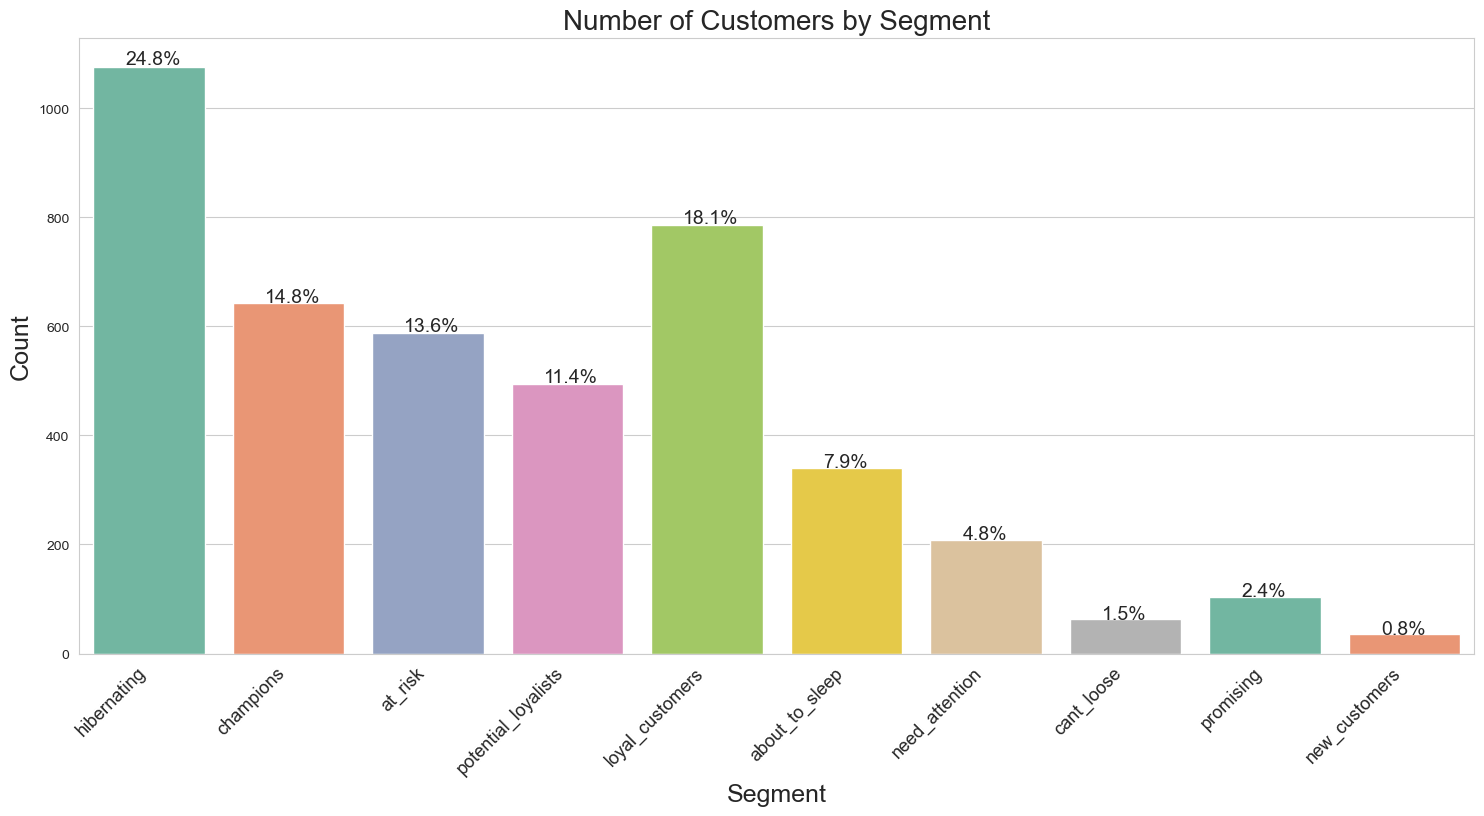

In [29]:
# 세그먼트의 카운트플롯을 해본다.

plt.figure(figsize=(18, 8))
ax = sns.countplot(data=rfm, x="segment", palette=palette)

total = len(rfm)
for patch in ax.patches:
    percentage = "{:.1f}%".format(patch.get_height() / total * 100)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size=14)
plt.title("Number of Customers by Segment", size=20)
plt.xlabel("Segment", size=18)
plt.ylabel("Count", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=13)
plt.show()

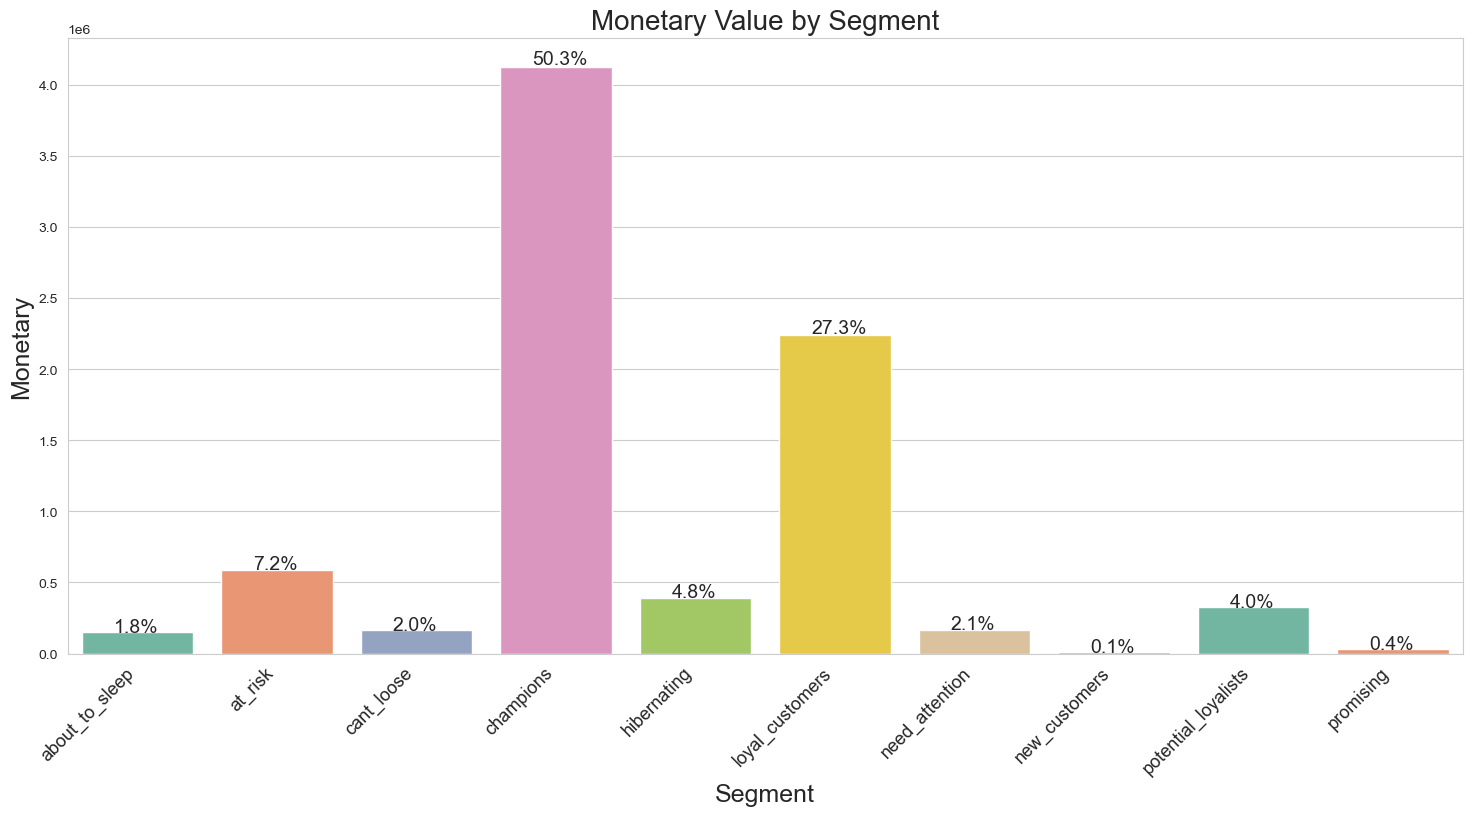

In [30]:
# 또한 세그먼트 별 매출액 플롯을 그려본다.

# First of all, create a pivot table
rfm_rev = rfm.groupby("segment")[["monetary"]].agg("sum").reset_index()

# Code a bar plot
plt.figure(figsize=(18, 8))
ax2 = sns.barplot(data=rfm_rev, x="segment", y="monetary", palette=palette)

total_rev = rfm_rev.monetary.sum()
for patch in ax2.patches:
    percentage = "{:.1f}%".format(patch.get_height() / total_rev * 100)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax2.annotate(percentage, (x, y), size=14)
plt.title("Monetary Value by Segment", size=20)
plt.xlabel("Segment", size=18)
plt.ylabel("Monetary", size=18)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right", size=13)
plt.show()

- 온라인몰의 중요한 고객군은 champions, loyal customers, potential loyalists으로 이 세 그룹은 전체 고객의 44.3%을 차지하는데 매출에 있어서는 81.6%를 내고 있으며 이에 반면 ibernating, at-risk, about-to-sleep 그룹은 전체 고객의 46.3%을 차지하지만 매출에 있어서는 13.8%밖에 차지하지 않는 것을 알 수 있다. 특히 champions 고객은 저첸의 14.8% 밖에 차지하지 않지만 전체 매출의 반이상을 차지하고 있다.

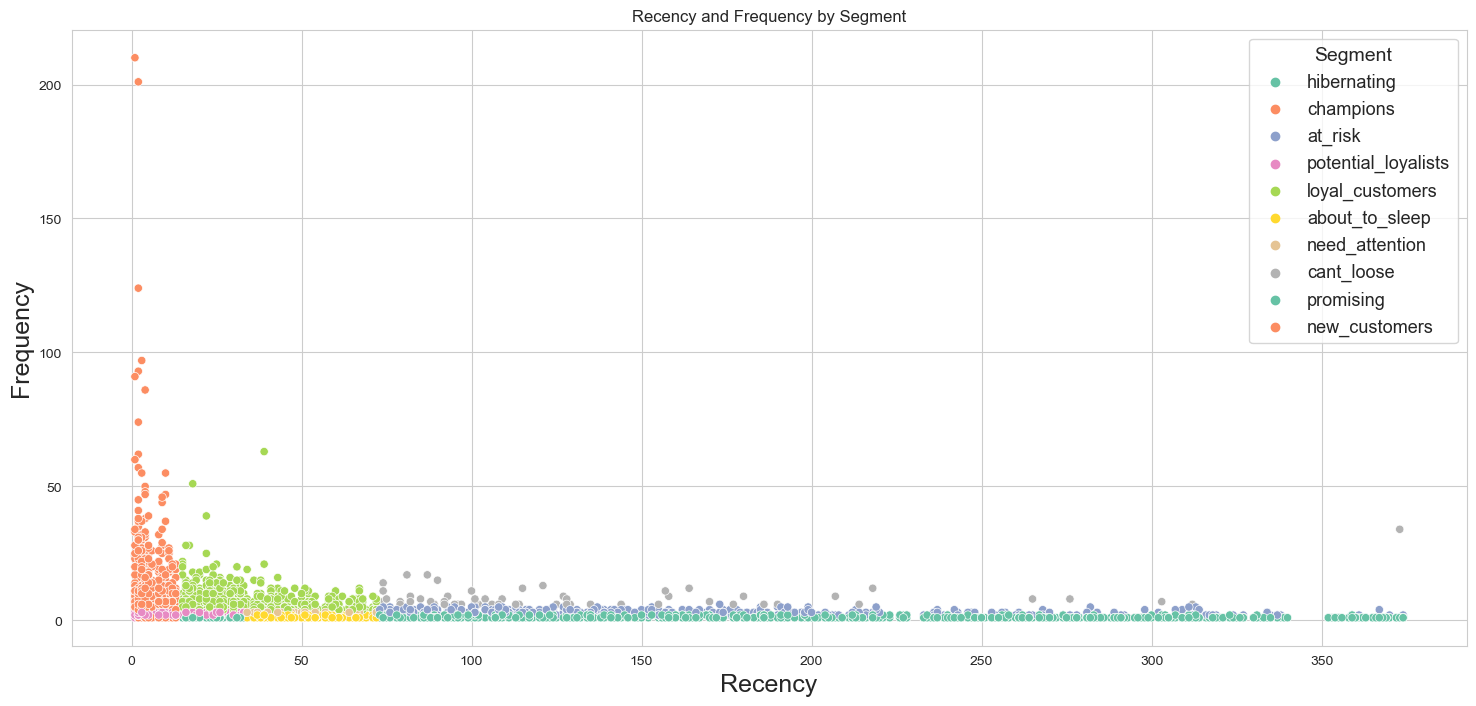

In [31]:
# 세그먼트별 recency, frequecy 의 스캐터 플롯을 그려본다.
plt.figure(figsize=(18, 8))
sns.scatterplot(data=rfm, x="recency", y="frequency", hue="segment", palette=palette)
plt.title("Recency and Frequency by Segment")
plt.xlabel("Recency", size=18)
plt.ylabel("Frequency", size=18)
plt.legend(loc="best", fontsize=13, title="Segment", title_fontsize=14)
plt.show()

특별히 충성도가 높거나, 구매 금액이 큰 유저들이 구매한 상품특성을 조사하자

In [32]:
item_segment = pd.merge(df[['CustomerID','Description','TotalPrice']], 
                        rfm[['CustomerID', 'segment']], on='CustomerID')
item_segment = item_segment.groupby(['segment', 'Description'])[['TotalPrice']].sum().reset_index()

# 세그먼트별 판매량에 따른 순위를 매긴다
item_segment['ranking'] = item_segment.groupby(
    'segment')['TotalPrice'].rank(method='first', ascending=False)
item_segment.sort_values(['segment', 'ranking'], inplace=True)

# 세그먼트별로 상위 3개의 제품을 찾는다.
item_segment[((item_segment['segment'] == 'champions') 
             | (item_segment['segment'] == 'loyal_customers')) & (item_segment['ranking'] < 4)]

,segment,Description,TotalPrice,ranking
9393,champions,REGENCY CAKESTAND 3 TIER,83032.950,1.0
10282,champions,WHITE HANGING HEART T-LIGHT HOLDER,44843.350,2.0
8461,champions,JUMBO BAG RED RETROSPOT,44461.410,3.0
15783,loyal_customers,REGENCY CAKESTAND 3 TIER,35336.550,1.0
15645,loyal_customers,POSTAGE,26245.370,2.0
14915,loyal_customers,JUMBO BAG RED RETROSPOT,23052.795,3.0


### 결과 분석:
1. 온라인몰의 중요한 고객군은 champions, loyal customers 으로 이 두 그룹은 전체 고객의 약 32%을 차지하는데 매출에 있어서는 80%를 내고 있으며 이에 반면 ibernating, at-risk, about-to-sleep 그룹은 전체 고객의 46.3%을 차지하지만 매출에 있어서는 13.8%밖에 차지하지 않는 것을 알 수 있다. 특히 champions 고객은 저첸의 14.8% 밖에 차지하지 않지만 전체 매출의 반이상을 차지하고 있다.

### 결과 활용 방안:
1. '이미 떠난 고객 / 떠나갈 조짐이 보이는 고객'인 hibernating/at_risk 세그먼트 고객에게 우리 서비스를 리마인드할 수 있는 메일을 보내보도록 한다.
2. 파레토 법칙(상위 20% 고객이 80%의 매출을 담당)과 같이 매출액에 대해 주요 고객집단인 champions, loyal customers차지하는 비중이 전체 매출의 80%을 차지하며 두 고객집단에 마케팅 전략이 집중되어야 한다.
3. 특별히 충성도은 그룹인 champions가 가장 많이 사용하는 상위 3위 제품은 REGENCY CAKESTAND 3 TIER, WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG RED RETROSPOT으로 이 제품을 다른 유저들도 사용하도록 쿠폰 지급 등의 프로모션을 진행할 수 있다.
4. 이 프로젝트에서는 확인할 수 없으나 충성도가 높은 사용자들이 많이 방문한 페이지, 많이 사용한 기능을 탐색하고 이를 일반 유저들도 많이 이용하도록 유도하도록 한다.

# 6. Cohort Analysis

첫 주문을 한 달을 기준으로 고객의 리텐션을 계산한다. 리텐션은 월별로 계산하면 2010년 12월부터 2011년 12월까지 1년간을 계산한다. 또한 Cohort별 ARPPU(Average Revenue per Paying User)도 함께 구해보자.

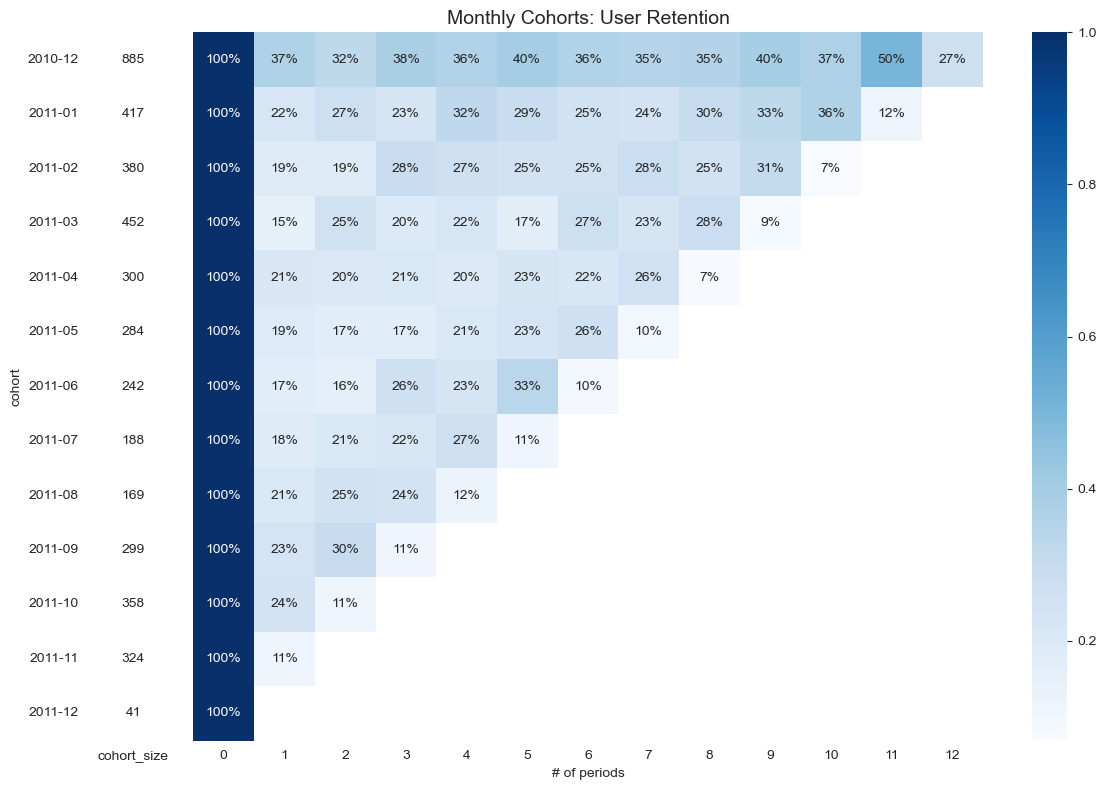

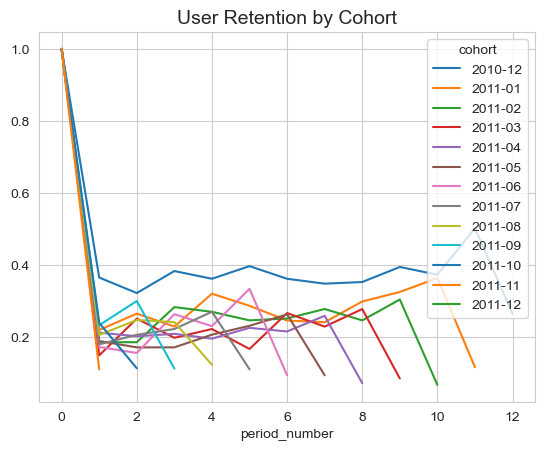

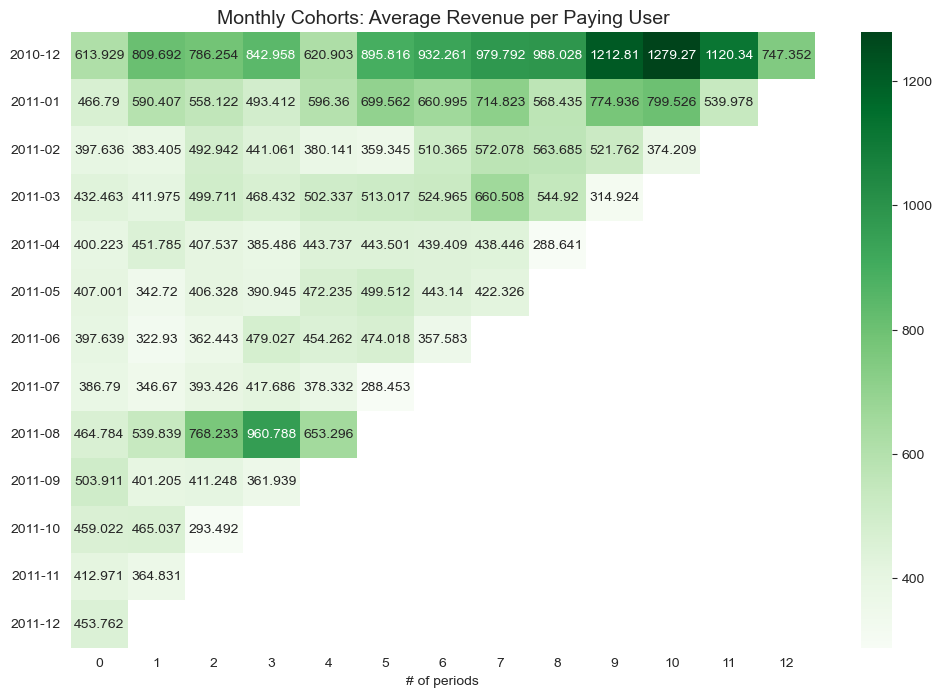

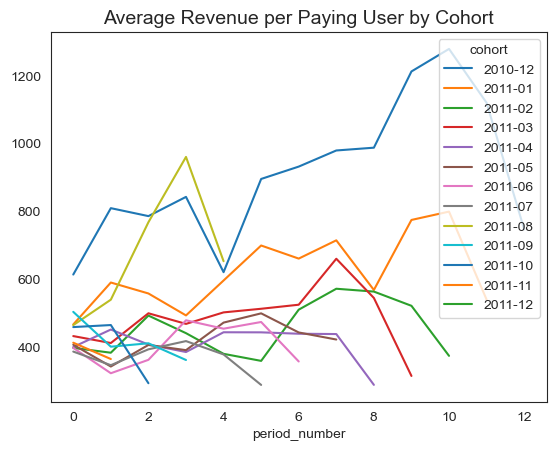

In [40]:
def CohortAnalysis(dataframe):
    # 우선 코호트 분석을 위한 표를 만든다.
    
    data = dataframe.copy()
    
    # CustomerID, InvoiceNo, InvoiceDate 열에 있는 중복값을 제거한다.
    
    data = data.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate'])[['TotalPrice']].sum()
    data.reset_index(inplace=True)
    
    # 새로운 order_month 열을 만든다.
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    
    # 고객의 구입한 가장 빠른 달을 기준으로 코호트를 만든다.
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M"))
    
    
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"), n_revenue=('TotalPrice', 'sum'))
        .reset_index())
    
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n"))
    
    # 리텐션 피봇 테이블을 만든다.
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers")
    
    # 코호트 그룹의 사이즈는 첫번째 구매월로 정한다.
    cohort_size = cohort_pivot.iloc[:, 0]

    # 고객의 월별 수는 코호트 사이즈 수로 나눈다.
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    
    
    # 월별 판매금액 피봇 테이블을 만든다.
    rev_cohort_pivot = cohort_data.pivot_table(
    values='n_revenue', index='cohort',columns='period_number')
    
    # ARPPU는 월별 판매금액 피봇 테이블에 리텐션 피봇테이블로 나눈다.
    arppu_matrix = rev_cohort_pivot / cohort_pivot
    
    # 월별 리텐션의 히트맵과 라인 플롯을 그린다.
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=True,
            fmt=".0%",
            cmap="Blues",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
        
    retention_matrix.T.plot()
    plt.title('User Retention by Cohort',fontsize=14)
    plt.show()
    
    # 월별 ARPPU 히트맵과 히트맵과 라인 플롯을 그린다.
    with sns.axes_style("white"):
        plt.figure(figsize=(12,8))
        ax = sns.heatmap(
            arppu_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=True,
            fmt="g",
            cmap="Greens"
        )
        ax.set_title("Monthly Cohorts: Average Revenue per Paying User", fontsize=14)
        ax.set(xlabel="# of periods", ylabel="")
        
        arppu_matrix.T.plot()
        plt.title('Average Revenue per Paying User by Cohort',fontsize=14)
        plt.show()
    
    
CohortAnalysis(df)

### 결과 분석 및 활용 방안 
1. 코호트별 기간에 따른 리텐션 추이를 보면 시간이 지날 수록 리텐션이 안정화되는 지점이 2010-12월 코호트의 40%에서 20%로 점점 낮아지고 있다. 또한 1개월이 지났을 때 리테션 추이도 2010-12 코호트 37%에서 2011-11월 코호트 11%까지 떨어져 리텐션을 올리기 위한 조치가 필요해 보인다.
2. 코호트별 ARPPU가 동일 코호트내에서 시간이 갈수록 대체로 안정화 단계에서 ARPPU가 증가하는 점은 고무적이긴 하나  2010-12월 코호트에서 최신 2011-12 코호트로 갈수록 감소하는 추세로  사용자의 경험에 해당하는 활성화 단계 개선 시급해 보인다.

결과 분석:
1. CLV 값이 2010-12 코호트에서 £283에서 시작하여 감소하여 2011-4월 코호트에서 최저치 £122를 찍고 2011-5 코호트부터 증가하여 2011-11 코호트는 가장 높은 CLV £346를 기록하여 온라인몰의 CLV가 점차 증가하는 좋은 흐름을 보였다. 하지만 CLV가 상승하다 안정화하는 시점에는 아직 이르렀다고는 할 수 없다.

참고: 2012-12 코호트의 데이터 기간은 9일로 다른 코호트는 최소 한달 기준에 비해 짧아 CLV 비교에서 제외한다. 

# 7. Customer Lifetime Value

고객 생애 가치를 계산해 보는데, 고객 생애 가치는 고객의 전생애간 고객이 만들어 내는 금전적, 경제적 가치를 의미한다.

In [69]:
# lifetimes.utils 모듈의 summary_data_from_transaction_data 함수로 R, F, M, T를 만든다.

metrics_df = summary_data_from_transaction_data(df
                                                , customer_id_col = 'CustomerID'
                                               , datetime_col='InvoiceDate'
                                               , monetary_value_col='TotalPrice'
                                               , observation_period_end=today_date)

metrics_df

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,327.0,0.000000
12347,6.0,365.0,369.0,599.701667
12348,3.0,283.0,360.0,298.540000
12349,0.0,0.0,20.0,0.000000
12350,0.0,0.0,312.0,0.000000
...,...,...,...,...
18280,0.0,0.0,279.0,0.000000
18281,0.0,0.0,182.0,0.000000
18282,1.0,119.0,128.0,77.840000


각 컬럼에 대한 설명이다.

- frequency(F): 고객별 구매 일수
- recency(R): 고객별 첫 구매에서 마지막 구매까지의 일수
- T(T): 고객별 첫 구매에서 집계일까지의 시간
- monetary_value(M): 고객별 평균 구매 금액

### 최적의 L2 penalty 파리미터 찾기

1. RFMT를 구했으니 이 데이터를 BG/NBD, Gamma-Gamma 모델에 넣어 주면 됩니다. 그런데 모델에 penalizer_coef 인자에 L2 penalty 를 넣어주면 좀더 성능을 향상시킬수 있다. L2 penalty sms 0.001~0.1 로 넣어야 효과적이다.
2. 최적의 L2 penalty를 구하기 위해서 데이터를 훈련하고 테스트 과정을 거친다. 훈련데이터를 calibration data, 테스트 데이터를 holdout data라고 부르면 1년 기간의 데이터 중 마지막 90일을 holdout data로 정한다.

In [73]:
holdout_days = 90

calibration_end_date = today_date - timedelta(days=holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                             ,customer_id_col='CustomerID'
                                             ,datetime_col='InvoiceDate'
                                             ,calibration_period_end=calibration_end_date
                                             ,observation_period_end=today_date
                                             ,monetary_value_col='TotalPrice')
metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,237.0,0.0000,0.0,0.000000,90.0
12347,4.0,238.0,279.0,519.7675,2.0,26.192069,90.0
12348,2.0,110.0,270.0,294.2800,1.0,102.353333,90.0
12350,0.0,0.0,222.0,0.0000,0.0,0.000000,90.0
12352,3.0,34.0,208.0,176.7700,3.0,19.777234,90.0


duration_holdout은 holdout data의 기간을 나타낸다.

In [118]:
# frequency가 0인 것은 제외하고 가져오는데, 이 고객들은 전체 기간 동안 구매 일수가 1일인 유저이다. 
# 이들은 “반복적인” 구매를 한 고객들이 아니라서 BG/NBD 모형 가정에서 벗어난 고객들이기 때문에 제외하고 적합해야 한다

whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df = metrics_cal_df[metrics_cal_df.frequency_cal >0]

L2 패널티 최적화하기

In [91]:
# score_model: 실제값과 예측값의 차이에 대한 지표(MSE, RMSE, MAE)을 계산하는 함수를 정의한다.
# 평가 지표의 default는 MSE로 한다

def score_model(actuals, predicted, metric='mse'):
    metric = metric.lower()
    
    if metric == 'mse' or metric == 'rsme':
        val = np.sum(np.square(actuals - predicted)) / actuals.shape[0]
    elif metric == 'rmse':
        val = np.sqrt(val)
    elif metric == 'mae':
        val = np.sum(np.abs(actuals - predicted)) / actuals.shape[0]
    else:
        val = None
        
    return val


# evaluate_bgnbd_model: calibration data와 l2_reg를 넣어 BG/NBD 모형을 적합시키고
# hold-out data의 구매일수(frequency)에 대한 실제값과 예측값에 대한 MSE를 계산하는 함수를 정의한다

def evaluate_bgnbd_model(param):
    data = inputs
    l2_reg = param
    
    #모형 적합
    model = BetaGeoFitter(penalizer_coef = l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])
    
    #모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                       , data['recency_cal']
                                       , data['T_cal'])
    mse = score_model(frequency_actual, frequency_predicted, 'mse')
    
    return {'loss': mse, 'status': STATUS_OK}


# evaludate_gg_model: calibration data와 l2_reg를 Gamma-Gamma 모형을 적합시키고
# hold-out data의 평균 구매 금액(monetary value)에 대한 실제값과 예측값에 대한 MSE를 계산하는 함수를 정의한다.

def evaluate_gg_model(param):
    data = inputs
    l2_reg = param
    
    # Gamma-Gamma 모형 적합
    model = GammaGammaFitter(penalizer_coef = l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])
    
    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(
    data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')
    
    return {'loss': mse, 'status': STATUS_OK}

hyperopt 모듈의 fmin함수를 이용해서 BG/NBD모형과 Gamma-Gamma모형 각각의 최적의 l2 penalty를 찾는다.

In [86]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
fn = evaluate_bgnbd_model, # 목적함수
space = search_space,      # 파라미터 공간
algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators(TPE)
max_evals = 100,           # 반복수
trials = trials)

l2_bgnbd = space_eval(search_space, argmin)
print(l2_bgnbd)

100%|████████| 100/100 [00:07<00:00, 13.96trial/s, best loss: 2.894956986787126]
0.9994399532453206


BG/NBD의 penalizer_coef = 0.9994399532453206 으로 정한다.

In [92]:
trials = Trials()

argmin = fmin(
fn = evaluate_gg_model,
space = search_space,
algo = algo,
max_evals = 100,
trials = trials)

l2_gg = space_eval(search_space, argmin)
print(l2_gg)

100%|███████| 100/100 [00:02<00:00, 36.48trial/s, best loss: 239.31593033812825]
0.011289905314884571


Gamma-Gamma의 penalizer_coef = 0.011289905314884571으로 정한다.

### BG/NBD 및 Gamma-Gamma모형 적합하기

최적의 l2 penalty를 찾았으므로 이를 BG/NBD와 Gamma-Gamma모형에 적합하고 holdout data를 입력하고 MSE를 구한다.

In [99]:
lifetimes_model = BetaGeoFitter(penalizer_coef = l2_bgnbd)

# calibration data의 R, F, T로 모형 적합한다
lifetimes_model.fit(filtered_df['frequency_cal'], 
                    filtered_df['recency_cal'], filtered_df['T_cal'])

# holdout 데이터롤 모델를 평가한다.
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout'],
                                              filtered_df['frequency_cal'],
                                              filtered_df['recency_cal'],
                                              filtered_df['T_cal'])
                                              
mse = score_model(frequency_actual, frequency_predicted, 'mse')
                                              
print('MSE: {0}'.format(mse))

MSE: 2.894956986787126


MSE 결과가 2.9정도되며 구매 일수에 대한 평균 제곱 오차가 약 ±2.9일임을 알 수 있다. 

In [100]:
# lifetimes_model을 통해 BG/NBD 모형에서 추정한 파라미터들을 확인할 수 있다.

lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.453092,0.009695,0.434090,0.472094
alpha,24.017543,1.011720,22.034573,26.000513
a,0.000523,0.000708,-0.000864,0.001910
b,0.012535,0.015672,-0.018182,0.043253


BG/NBD 모형은 다음과 같은 가정을 하고 있다.

1. 고객이 남아있는 동안 일정한 기간 T 동안의 구매 횟수는 Pois(λT)를 따른다. 1일간 Pois(1/12)를 따른다면 T=1년일 경우 pois(30)을 따른다.
(포아송의 모수인 λT는 예상 구매 횟수를 의미한다.)
2. 고객마다 일정한 기간동안 구매하는 회수는 이는 λ~Gamma(r,α)를 따른다.
3. j번째 구매가 마지막이고 더이상 구매하지 않을 확률(이탈률)은 p이다. 이탈할 때까지의 구매 횟수는 Geo(p)를 따른다.
4. 고객마다 더이상 구매하지 않을 확류(이탈률)은 다르다. 이탈률은 p~Beta(a,b)를 따른다.
5. 고객별 일정 기간동안의 구매 횟수와 구매하지 않을 확률은 서로 영향을 주지 않는다.

여기에 구매횟수 확률은 λ~ Gamma(r,α), p~ Beta(a,b)은 위의 표에서 추정하는 파라미터이다.

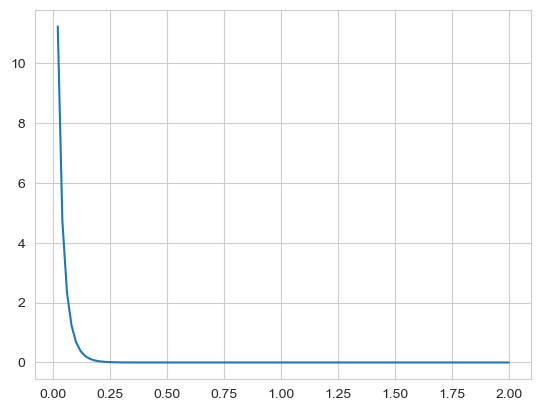

In [104]:
# 고객별 구매횟수 확률의 플롯을 그려본다.

from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x= np.linspace(0, 2, 100)
y = gamma.pdf(x, a=coefs['r'], scale = 1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수가 된다.

plt.plot(x, y)
plt.show()

0.2에서 부터 확률이 0으로 수렴하고 있는데 대부분 고객들의 1일 평균 구매 횟수는 최대 0.2임을 알 수 있다. 즉 최대 5일에 한번 꼴로 구매한다라고 볼 수 있다.

### Gamma-Gamma 모형 적합

In [108]:
spend_model = GammaGammaFitter(penalizer_coef = l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(
filtered_df['frequency_holdout'], filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 239.31593033812825


평균 구매 금액의 평균 제곱 오차는 £239정도 된다고 볼 수 있다.

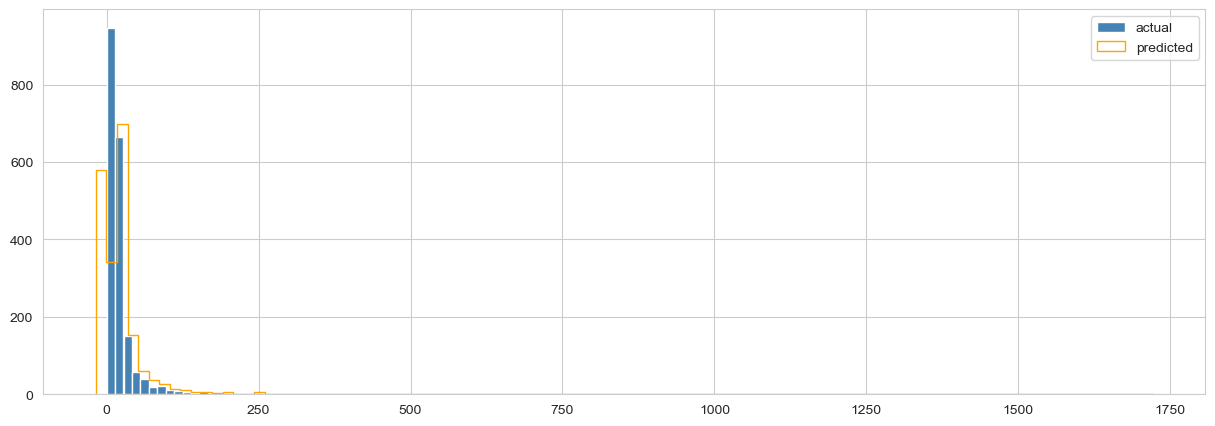

In [113]:
# 히스토그램를 통해 실제와 예측된 평균 구매 금액이 얼마나 차이가 나는지 살펴보자.

bins = 100
plt.figure(figsize=(15,5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='steelblue', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predicted', histtype='step', color='orange', rwidth=0.99)
plt.legend(loc='upper right')
plt.show()

실제값과 예측값의 분포가 어느정도 유사함을 알 수 있다.

### CLV 구하기

In [122]:
# calibration/holdout로 나뉘어진 데이터가 아닌 전체 데이터를 대상으로 LTV를 구해야하기 때문에 whole_filtered_df를 쓴다.
# 

final_df = whole_filtered_df.copy()

final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                    final_df['frequency'],
                                                    final_df['recency'],
                                                    final_df['T'],
                                                    final_df['monetary_value'],
                                                    time=12,
                                                    discount_rate=0.0022) # monthly discount rate => 연간 2.6%에 해당함

In [123]:
# 365일 동안의 예상 구매 회수를 구한다.

t = 365

final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(
t,
final_df['frequency'],
final_df['recency'],
final_df['T'])

In [125]:
# Gamma-Gamma 모평의 output인 예상 평균 구매 금액은 다음과 같이 구할 수 있다.

final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(
    final_df['frequency'], final_df['monetary_value'])

In [126]:
final_df

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
CustomerID,,,,,,,
12347,6.0,365.0,369.0,599.701667,3612.021984,5.991036,620.052573
12348,3.0,283.0,360.0,298.540000,1020.697127,3.279364,320.101018
12352,6.0,260.0,298.0,243.306667,1790.740931,7.310796,251.911488
12356,2.0,303.0,327.0,269.905000,744.266551,2.548419,300.356602
12358,1.0,149.0,152.0,671.440000,2343.454844,2.887652,834.622452
...,...,...,...,...,...,...,...
18272,5.0,244.0,248.0,487.752000,3611.799330,7.313811,507.878180
18273,2.0,255.0,259.0,76.500000,265.785451,3.160806,86.479397
18282,1.0,119.0,128.0,77.840000,325.767883,3.334355,100.478830


In [142]:
# fianal_df의 descriptive stats를 살펴보자.

final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,2790.0,4.454122,6.930419,1.000000,1.000000,3.000000,5.000000,131.000000
recency,2790.0,203.328674,111.459556,1.000000,106.000000,211.000000,301.750000,373.000000
T,2790.0,262.120789,101.480175,11.000000,199.250000,286.000000,360.000000,375.000000
monetary_value,2790.0,395.624797,442.892709,1.000000,185.307500,306.946667,452.540417,8671.891800
ltv,2790.0,2998.699354,9125.216786,11.133696,704.171346,1476.238880,2976.452056,252113.215719
predicted_purchases,2790.0,6.260440,6.852265,0.398486,2.591863,4.489411,7.638249,120.222159
predicted_monetary_value,2790.0,438.192050,475.530655,5.445819,207.800675,337.806774,500.284181,8738.946894


고객의 평균 구매 횟수는 약 6.3회, 평균 구매 금액은 £438, LTV(CLV)는 £2998정도 된다는 것을 알 수 있다.

In [141]:
# Top 10 LTV 고객을 알아보자

final_df.sort_values('ltv', ascending=False)[:10]

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
CustomerID,,,,,,,
14646,44.0,353.0,356.0,6047.558295,252113.215719,42.687083,6074.063183
18102,25.0,367.0,369.0,8671.891800,200818.206850,23.633289,8738.946894
14096,16.0,97.0,103.0,3359.947500,156262.018665,47.254688,3400.851148
14911,131.0,372.0,375.0,1057.185420,123765.972886,120.222159,1058.758632
17450,26.0,359.0,369.0,5005.259808,120426.031485,24.561394,5042.518938
12415,15.0,313.0,339.0,7556.773333,115606.554927,15.532262,7654.693947
14156,42.0,362.0,373.0,2751.950238,104893.155319,39.020239,2764.632653
17511,27.0,371.0,375.0,3300.981296,81164.312447,25.107034,3324.680419
16684,15.0,354.0,360.0,4075.991667,58952.404574,14.684048,4128.914195


LTV가 가장 높은 고객은 CustomerID = 14646으로 LTV가 £252,113으로 상위10순위내에서도 월등히 높다는 것을 알 수 있다. 다만 우려스러운 것은 3위 14096을 제외한 모든 Top 10 LTV 고객의 recency가 365일, 즉 1년 이상이 되어 이 온라인 리테일에서 이탈한 것으로 보인다는 것이다. LTV가 높은 고객은 기업에 있어서 가장 핵심적인 고객층이다. 이들을 끈끈히 잡을 수 있는 다음과 같은 다양한 마케팅 방안이 시급해 보인다.
- 이탈이 예상되는 VIP 고객을 잡기 위한 타겟 캠페인을 진행한다.
- 재구매 주기가 도래한 이탈 예상 고객 이탈 방지 캠페인 등을 진행한다.

### cohort별 평균 LTV를 계산하고 cohort별 변화 추이를 살펴보자

In [172]:
# 우선 고객별 cohort를 구한다.

cohort = df.groupby('CustomerID')[['InvoiceDate']].apply('min')
cohort['InvoiceDate'] = cohort['InvoiceDate'].dt.to_period('M')
cohort.columns = ['cohort']
cohort

,cohort
CustomerID,
12346,2011-01
12347,2010-12
12348,2010-12
12349,2011-11
12350,2011-02
...,...
18280,2011-03
18281,2011-06
18282,2011-08


In [173]:
len(final_df)

2790

In [178]:
# final_df와 cohort를 final_df의 CustomerID(구매횟수가 1회 이상인 고객리스트인 반면 cohort 데이터프레임은 전체 고객임)을 기준으로 merge한다. 

cohort_final = pd.merge(final_df, cohort, how='left', left_on='CustomerID', right_on='CustomerID')


,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value,cohort
CustomerID,,,,,,,,
12347,6.0,365.0,369.0,599.701667,3612.021984,5.991036,620.052573,2010-12
12348,3.0,283.0,360.0,298.540000,1020.697127,3.279364,320.101018,2010-12
12352,6.0,260.0,298.0,243.306667,1790.740931,7.310796,251.911488,2011-02
12356,2.0,303.0,327.0,269.905000,744.266551,2.548419,300.356602,2011-01
12358,1.0,149.0,152.0,671.440000,2343.454844,2.887652,834.622452,2011-07
...,...,...,...,...,...,...,...,...
18272,5.0,244.0,248.0,487.752000,3611.799330,7.313811,507.878180,2011-04
18273,2.0,255.0,259.0,76.500000,265.785451,3.160806,86.479397,2011-03
18282,1.0,119.0,128.0,77.840000,325.767883,3.334355,100.478830,2011-08


In [183]:
cohort_ltv = cohort_final.groupby('cohort')[['ltv']].mean()
cohort_ltv

,ltv
cohort,
2010-12,4822.403451
2011-01,2667.182677
2011-02,1865.118564
2011-03,1997.082141
2011-04,1725.418264
2011-05,1711.595758
2011-06,1923.150764
2011-07,1855.256259
2011-08,3776.835522


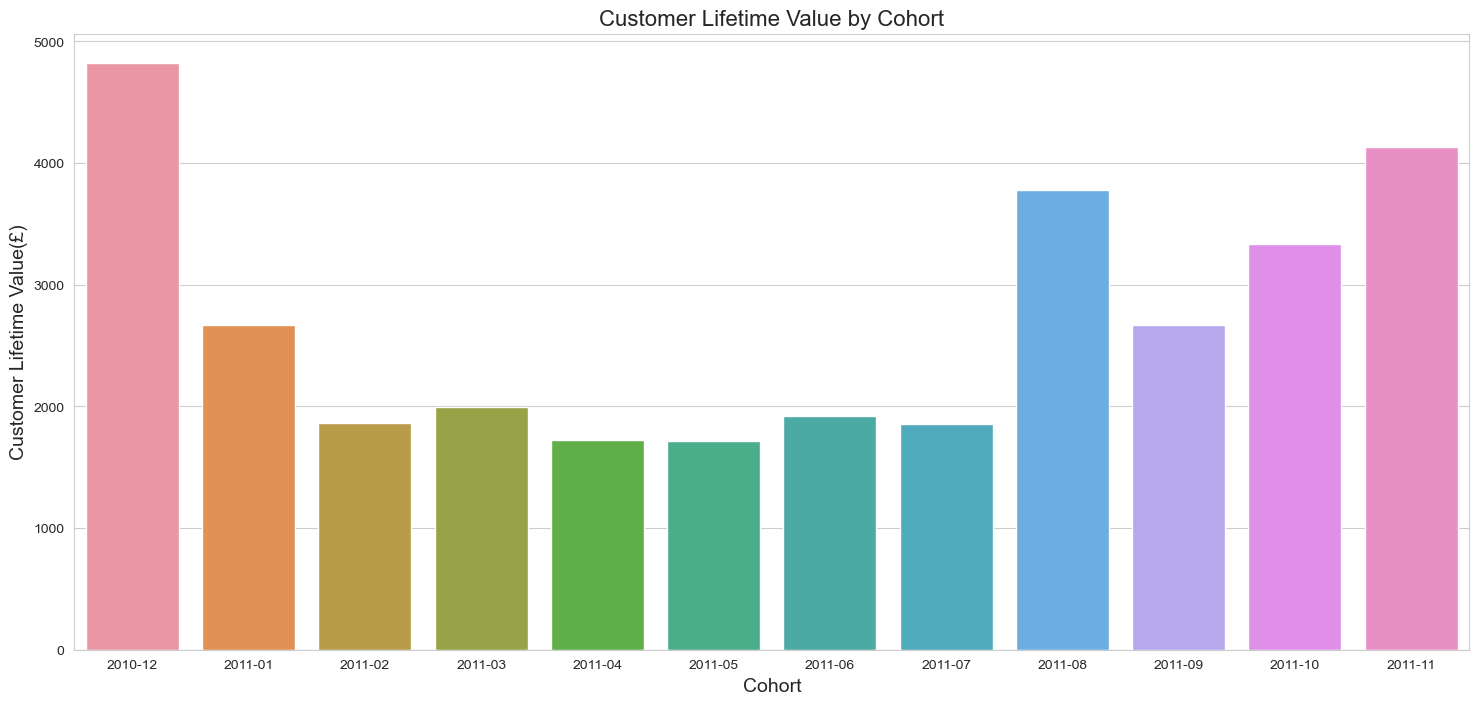

In [191]:
# 1년(365일) 코호트별 CLV의 라인 플롯을 시각화하여 코호트별 변화 추이를 살펴본다.


plt.figure(figsize=(18,8))

sns.barplot(cohort_ltv.index, cohort_ltv['ltv'])
plt.title('Customer Lifetime Value by Cohort', fontsize=16)
plt.xlabel('Cohort', fontsize=14)
plt.ylabel('Customer Lifetime Value(£)', fontsize=14)

plt.show()

 결과 분석:
1. CLV 값이 2010-12 코호트에서 £4822에서 시작하여 감소하여 2011-5월 코호트에서 최저치 £1711를 찍고 2011-8 코호트에 크게 증가, 그 뒤에서도 계속 증가하는 추세를 보여서 온라인몰의 CLV가 점차 증가하는 좋은 흐름을 보였다. 하지만 CLV가 상승하는 추세이긴 하지만 LTV값이 수렴하는 안정화하는 시점에는 이르렀다고는 볼 수 없다.
2. CAC(고객 획득 비용)을 알 수 있다면 코호트별 LTV 변화 추이와 비교하여 수익의 안정화 정도를 분석할 수 있다. 보통 LTV가 CAC의 3~5배 정도는 되면 안정화되었다고 할 수 있다.